In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

import re

from tqdm import tqdm
from datetime import datetime



import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
register_matplotlib_converters()


# Volume Data

In [2]:
df_vol = pd.read_csv("../data/inbound_volume_data.csv", index_col=0)

### 1. Initial reading

In [3]:
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
0,2015/07,Provider_1,Plant_1,19096,20298
1,2015/08,Provider_1,Plant_1,187139,189973
2,2015/09,Provider_1,Plant_1,181149,187798
3,2015/10,Provider_1,Plant_1,202677,202327
4,2015/11,Provider_1,Plant_1,272902,271765


In [4]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Timestamp          47058 non-null  object
 1   Provider           47058 non-null  object
 2   Plant              47058 non-null  object
 3   Actual Vol [Kg]    47055 non-null  object
 4   Expected Vol [Kg]  46951 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [5]:
df_vol.describe()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
count,47058,47058,47058,47055,46951
unique,106,38,18,45291,46179
top,2018/08,Provider_3,Plant_19,160,0
freq,493,1779,2922,17,57


### 2. Data type editing

#### 2.1 Time 

In [6]:
df_vol["Timestamp"]=pd.to_datetime(df_vol["Timestamp"], format="%Y/%m")

In [7]:
#This is other way to do this conversion 
"""
df_vol["Year"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[0]).astype(int)
df_vol["Month"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[1]).astype(int)
df_vol["Timestamp"] = df_vol[["Year", "Month"]].apply(
    lambda x: datetime(x["Year"], x["Month"], 1), axis=1
)
"""

'\ndf_vol["Year"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[0]).astype(int)\ndf_vol["Month"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[1]).astype(int)\ndf_vol["Timestamp"] = df_vol[["Year", "Month"]].apply(\n    lambda x: datetime(x["Year"], x["Month"], 1), axis=1\n)\n'

#### 2.2 Numeric
 
We need to check first if the numeric values we have have non-numeric characters. This is important since we could have other special character in between the numbers which will provoke a ValueError when trying to parse it to string.

In [8]:
def non_numeric_characters(input_string: str) -> str:
    """
    Define a regular expression pattern
    to match any non-digit character
    """
    pattern = re.compile(r"\D")
    non_numeric_chars = pattern.findall(str(input_string))
    return str(non_numeric_chars)

In [9]:
# Find all non-numeric characters
df_vol["Actual Vol [Kg]"].dropna().apply(non_numeric_characters).unique()

array(['[]', "['.']", "['.', '.']"], dtype=object)

In [10]:
df_vol["Expected Vol [Kg]"].dropna().apply(non_numeric_characters).unique()

array(['[]', "[',']", "['.']", "['.', '.']"], dtype=object)

In [11]:
# We can verify by ourselves which datapoints contain
# (.) in the Column "Actual Vol [Kg]"
df_vol[
    df_vol["Actual Vol [Kg]"].apply(lambda x: True if "." in str(x) else False)
].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
55308,2022-01-01,Provider_2,Plant_4,784.974,758.414
55309,2022-01-01,Provider_3,Plant_4,1.736.973,1.544.132
55310,2022-01-01,Provider_4,Plant_4,417.621,1.002.859
55311,2022-01-01,Provider_5,Plant_4,2.535.036,2.699.221
55312,2022-01-01,Provider_6,Plant_4,98.101,98.348


In [12]:
# We can verify by ourselves which datapoints contain
# (.) in the Column "Expected Vol [Kg]"
df_vol[
    df_vol["Expected Vol [Kg]"].apply(lambda x: True if "." in str(x) else False)
].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
11925,2016-10-01,Provider_16,Plant_1,1937,2.026
11926,2016-11-01,Provider_16,Plant_1,159462,156.923
11927,2016-12-01,Provider_16,Plant_1,371940,371.941
11928,2017-01-01,Provider_16,Plant_1,409358,409.111
11929,2017-02-01,Provider_16,Plant_1,347810,341.743


On this analysis we noticed that on Actual Vol the only non numeric character is the . and we realized it was used to mark the division between thousands. so we will replace it by an empty string. On the other hand the Expected vol has both . and , so we need first to replace the . by an empty string and then the , by a . 

And in both cases set this data as type float. 

In [13]:

df_vol["Actual Vol [Kg]"] = df_vol["Actual Vol [Kg]"].str.replace(".", "")
df_vol["Actual Vol [Kg]"]=pd.to_numeric(df_vol["Actual Vol [Kg]"],errors="coerce")
df_vol["Expected Vol [Kg]"] = df_vol["Expected Vol [Kg]"].str.replace(".", "")
df_vol["Expected Vol [Kg]"] = df_vol["Expected Vol [Kg]"].str.replace(",", ".")
df_vol["Expected Vol [Kg]"]=pd.to_numeric(df_vol["Expected Vol [Kg]"],errors="coerce")

df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
0,2015-07-01,Provider_1,Plant_1,19096.0,20298.0
1,2015-08-01,Provider_1,Plant_1,187139.0,189973.0
2,2015-09-01,Provider_1,Plant_1,181149.0,187798.0
3,2015-10-01,Provider_1,Plant_1,202677.0,202327.0
4,2015-11-01,Provider_1,Plant_1,272902.0,271765.0


We noticed that the numbers on Kg are two big to handle so it would be useful to convert them to tons. 

In [14]:
df_vol["Actual Vol [Tons]"] = np.round(df_vol["Actual Vol [Kg]"] / 1000, 3)
df_vol["Expected Vol [Tons]"] = np.round(df_vol["Expected Vol [Kg]"] / 1000, 3)

In [15]:
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Actual Vol [Tons],Expected Vol [Tons]
0,2015-07-01,Provider_1,Plant_1,19096.0,20298.0,19.096,20.298
1,2015-08-01,Provider_1,Plant_1,187139.0,189973.0,187.139,189.973
2,2015-09-01,Provider_1,Plant_1,181149.0,187798.0,181.149,187.798
3,2015-10-01,Provider_1,Plant_1,202677.0,202327.0,202.677,202.327
4,2015-11-01,Provider_1,Plant_1,272902.0,271765.0,272.902,271.765


### 3. Secondary analysis

In [16]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            47058 non-null  datetime64[ns]
 1   Provider             47058 non-null  object        
 2   Plant                47058 non-null  object        
 3   Actual Vol [Kg]      47055 non-null  float64       
 4   Expected Vol [Kg]    46951 non-null  float64       
 5   Actual Vol [Tons]    47055 non-null  float64       
 6   Expected Vol [Tons]  46951 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 2.9+ MB


In [17]:
df_vol.describe()


,Timestamp,Actual Vol [Kg],Expected Vol [Kg],Actual Vol [Tons],Expected Vol [Tons]
count,47058,4.705500e+04,4.695100e+04,47055.000000,46951.000000
mean,2018-05-12 19:43:06.510263552,4.446285e+05,8.292719e+05,444.628452,829.271898
min,2014-01-01 00:00:00,1.000000e+00,0.000000e+00,0.001000,0.000000
25%,2016-05-01 00:00:00,7.908550e+04,6.820250e+04,79.085500,68.202500
50%,2018-06-01 00:00:00,2.480090e+05,2.206440e+05,248.009000,220.644000
75%,2020-06-01 00:00:00,5.767820e+05,5.253174e+05,576.782000,525.317500
max,2022-10-01 00:00:00,5.880148e+07,5.165009e+08,58801.478000,516500.852000
std,NaN,7.162504e+05,9.156459e+06,716.250404,9156.458726


We need to group the information by the singular combination plant- Provider, lets see first how mani we have.

In [18]:
df_vol.groupby(["Plant","Provider"]).count()
   

Timestamp  Actual Vol [Kg]  Expected Vol [Kg]  \
Plant   Provider                                                     
Plant_1 Provider_1          48               48                 48   
        Provider_10         88               88                 88   
        Provider_14         87               87                 87   
        Provider_15         43               43                 43   
        Provider_16         38               38                 38   
...                        ...              ...                ...   
Plant_9 Provider_5          93               93                 93   
        Provider_6          93               93                 93   
        Provider_7          93               93                 93   
        Provider_8          93               93                 93   
        Provider_9          93               93                 93   

                     Actual Vol [Tons]  Expected Vol [Tons]  
Plant   Provider                                             
Plant_1 Provider_1                  48                   48  
        Provider_10                 88                   88  
        Provider_14                 87                   87  
        Provider_15                 43                   43  
        Provider_16                 38                   38  
...                                ...                  ...  
Plant_9 Provider_5                  93                   93  
        Provider_6                  93                   93  
        Provider_7                  93                   93  
        Provider_8                  93                   93  
        Provider_9                  93                   93  

[624 rows x 5 columns]

#### Create a Timeseries Key

The timeseries key or tskey is like the index we are going to use to analyze 

In [19]:
# Create Timeseries Key
df_vol["ts_key"] = df_vol[["Provider", "Plant"]].apply(
    lambda x: x["Provider"] + "-" + x["Plant"], axis=1
)
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Actual Vol [Tons],Expected Vol [Tons],ts_key
0,2015-07-01,Provider_1,Plant_1,19096.0,20298.0,19.096,20.298,Provider_1-Plant_1
1,2015-08-01,Provider_1,Plant_1,187139.0,189973.0,187.139,189.973,Provider_1-Plant_1
2,2015-09-01,Provider_1,Plant_1,181149.0,187798.0,181.149,187.798,Provider_1-Plant_1
3,2015-10-01,Provider_1,Plant_1,202677.0,202327.0,202.677,202.327,Provider_1-Plant_1
4,2015-11-01,Provider_1,Plant_1,272902.0,271765.0,272.902,271.765,Provider_1-Plant_1


#### Timeseries keys Analysis

We need to know how long this timeseries is, so we need to know what are the min am max dates available among all time series. 

Having that information we need to check if all the timeseries have data until the last date we have information. If we don't have information that means that, that supplier has stop providing to that plant so that timeseries can't be included on the analysis and need to be remove. 



In [20]:
df_vol["ts_len"] = df_vol.groupby("ts_key")["Timestamp"].transform(lambda x: len(x))

# Create a Summary of all columns
df_vol_summary = df_vol.groupby(["ts_key"]).agg(["min", "max"])
df_vol_summary.columns = ["-".join(x) for x in df_vol_summary.columns]
df_vol_summary = df_vol_summary.reset_index()

df_vol_summary.head()

,ts_key,Timestamp-min,Timestamp-max,Provider-min,Provider-max,Plant-min,Plant-max,Actual Vol [Kg]-min,Actual Vol [Kg]-max,Expected Vol [Kg]-min,Expected Vol [Kg]-max,Actual Vol [Tons]-min,Actual Vol [Tons]-max,Expected Vol [Tons]-min,Expected Vol [Tons]-max,ts_len-min,ts_len-max
0,Provider_1-Plant_1,2015-07-01,2019-06-01,Provider_1,Provider_1,Plant_1,Plant_1,19096.0,587616.0,20298.000,531722.00,19.096,587.616,20.298,531.722,48,48
1,Provider_1-Plant_10,2014-01-01,2019-06-01,Provider_1,Provider_1,Plant_10,Plant_10,18723.0,125475.0,0.000,118138.94,18.723,125.475,0.000,118.139,66,66
2,Provider_1-Plant_11,2015-01-01,2019-06-01,Provider_1,Provider_1,Plant_11,Plant_11,3649.0,335834.0,13373.000,298463.00,3.649,335.834,13.373,298.463,48,48
3,Provider_1-Plant_12,2014-01-01,2019-06-01,Provider_1,Provider_1,Plant_12,Plant_12,224448.0,603847.0,217346.995,542661.00,224.448,603.847,217.347,542.661,66,66
4,Provider_1-Plant_13,2014-01-01,2019-06-01,Provider_1,Provider_1,Plant_13,Plant_13,158588.0,1173034.0,154686.111,1143231.00,158.588,1173.034,154.686,1143.231,66,66


In [21]:
print(
    " The min date available among all timeseries is: ",
    df_vol_summary["Timestamp-min"].min(),
)
print(
    " The max date available among all timeseries is: ",
    df_vol_summary["Timestamp-max"].max(),
)

print(" The min ts length is: ", df_vol_summary["ts_len-min"].min())
print(" The max ts length is: ", df_vol_summary["ts_len-max"].max())


 The min date available among all timeseries is:  2014-01-01 00:00:00
 The max date available among all timeseries is:  2022-10-01 00:00:00
 The min ts length is:  1
 The max ts length is:  113


We will count the timeseries that go up to oct 2022 to do that we will filter filter the df_vol_summary DataFrame to include only those rows where the maximum timestamp ('Timestamp-max') is equal to the overall maximum timestamp in the entire DataFrame (df_vol_summary["Timestamp-max"].max()). 

In [22]:

ts_with_current_data = df_vol_summary[
    df_vol_summary["Timestamp-max"] == df_vol_summary["Timestamp-max"].max()
]["ts_key"].nunique() #nunique is a method returns the number of unique values

#print the information
print(" Number of Total Time Series Available: ", df_vol_summary["ts_key"].nunique())
print(" Number of time series with data until October 2022: ", ts_with_current_data)

print(
    " % of Time Series Available over the total: ",
    np.round(ts_with_current_data / df_vol_summary["ts_key"].nunique(), 2) * 100,
    " %",
)

 Number of Total Time Series Available:  624
 Number of time series with data until October 2022:  306
 % of Time Series Available over the total:  49.0  %


### Data Filtering

Now that we know that we only can work with 49% of the ts_keys we need to filter them and overwrite df_vol with the data we will work from now on.

In [23]:
valid_ts = df_vol_summary[
    df_vol_summary["Timestamp-max"] == df_vol_summary["Timestamp-max"].max()
]["ts_key"].unique()

# Now we just keep those valid timeseries from the data we overwrite our dataset
df_vol = df_vol[df_vol["ts_key"].isin(valid_ts)].copy()

# We just verify our filter was made correctly
# We validate that all ts_key in our new df_vol
# are the same as the one in the list valid_ts
assert set(df_vol["ts_key"].unique()) == set(valid_ts), "There are missing timeseries"

print("Number of available timeseries after filtering:", df_vol["ts_key"].nunique())



Number of available timeseries after filtering: 306


### Data Completeness

We need to consider that a provider will deliver to a plant multiple times during the month. So we need to:

1. create a "validator" a table that only takes out of our current df_vol the date (Timestamp), the ts_key and the actual volume.And count the amount of registers we have on each  month by each plan-provider combination. We noticed that on Nov of 2014 the plant 19 received 8 times from the provider 27. that is the only one the rest have just received one pre month from each provider. 

In [24]:
# The idea is the for every "Timestamp","ts_key" combination
# there should be only one entry for the column "Actual Vol [Kg]"
df_vol_validator = (
    df_vol[["Timestamp", "ts_key", "Actual Vol [Kg]"]]
    .groupby(["Timestamp", "ts_key"])
    .count()
    .rename(columns={"Actual Vol [Kg]": "n_values"})
    .reset_index()

)

In [25]:
df_vol_validator[df_vol_validator["n_values"] > 1].head()

,Timestamp,ts_key,n_values
1920,2014-11-01,Provider_27-Plant_19,8


Having this information, the next step would be to group all the registers by month (timeseries) and  ts Key. To do this we need to sum up the values when we have multiple registers for the same timestamp and the same ts_key.

In [26]:
df_vol_c = (
    df_vol[["Timestamp", "ts_key", "Actual Vol [Tons]", "Expected Vol [Tons]"]]
    .groupby(["Timestamp", "ts_key"], group_keys=False)
    .agg(
        {
            "Actual Vol [Tons]": sum,
            "Expected Vol [Tons]": sum,
        }
    )
    .reset_index()
    .set_index("Timestamp")
)

In [27]:
# Verify that every Timestamp-Plant combination only contains one entry
df_verify = (
    df_vol_c.groupby(["Timestamp", "ts_key"])["Actual Vol [Tons]"]
    .count()
    .to_frame()
    .rename(columns={"Actual Vol [Tons]": "n_values"})
)
assert df_verify["n_values"].unique() == np.array([1])

df_vol_c.head()
df_vol_c.to_csv("df_vol_c.csv") 

Not all providers send to all plants during all months so we need to fill those spaces with 0.

In [28]:
ts = pd.DataFrame()
# ref: https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases"
for ts_key in tqdm(df_vol_c["ts_key"].unique()):
    # build custom date range for timeseries
    idx = pd.date_range(
        start=df_vol_c[df_vol_c["ts_key"] == ts_key].index.min(),
        end=df_vol_c.index.max(),
        freq="MS",  # Start of month
        name="Timestamp",
    )

    # fill holes in time series
    df = df_vol_c.loc[df_vol_c["ts_key"] == ts_key].reindex(idx)
    df.fillna(
        {
            "ts_key": ts_key,
            "Actual Vol [Tons]": 0,
            "Expected Vol [Tons]": 0,
        },
        inplace=True,
    )
    df["Actual Vol [Tons]"] = df["Actual Vol [Tons]"].astype(np.float32)
    df["Expected Vol [Tons]"] = df["Expected Vol [Tons]"].astype(np.float32)

    if ts.empty:
        ts = df
    else:
        ts = pd.concat([ts, df])

    del df

100%|██████████| 306/306 [00:02<00:00, 149.90it/s]


In [29]:
# Create Column Plant
ts["Plant"] = ts["ts_key"].apply(lambda x: x.split("-")[1])

In [30]:
ts.head()


,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant
Timestamp,,,,
2014-01-01,Provider_10-Plant_10,476.199005,482.835999,Plant_10
2014-02-01,Provider_10-Plant_10,388.113007,388.118011,Plant_10
2014-03-01,Provider_10-Plant_10,527.382996,538.025024,Plant_10
2014-04-01,Provider_10-Plant_10,470.321991,483.035004,Plant_10
2014-05-01,Provider_10-Plant_10,500.139008,512.685974,Plant_10


# Production Data

In [31]:
df_prod = pd.read_csv("../data/production_data.csv", index_col=0)

In [32]:
df_prod.head()

,Timestamp,Plant_6,Plant_9,Plant_13,Plant_15,Plant_17,Plant_19,Plant_21,Plant_11,Plant_4,Plant_12,Plant_20,Plant_14,Plant_22,Plant_1,Plant_3,Plant_5,Plant_18,Plant_10
0,2014/01,11848,54138,33839,19438,6770,29098,45147,8578,326919,11668,93855,68067,13127,26363,26363,5799,13749,3633
1,2014/02,13528,53063,36690,24252,6943,26975,42656,9739,334540,11275,92865,66012,18565,29822,29822,7978,12880,2880
2,2014/03,12753,50551,38211,24978,7695,28991,46226,10619,356075,12306,99860,71251,19505,28915,28915,8149,13348,4165
3,2014/04,12681,52528,36979,23872,7436,27409,47929,10379,351736,11790,95409,66233,23983,29441,29441,5020,15650,4457
4,2014/05,13272,50855,31164,24145,7415,27959,47255,12155,332888,10407,97371,69890,21139,28110,28110,7087,15940,4035


In [33]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 119
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  120 non-null    object
 1   Plant_6    120 non-null    int64 
 2   Plant_9    120 non-null    int64 
 3   Plant_13   120 non-null    int64 
 4   Plant_15   120 non-null    int64 
 5   Plant_17   120 non-null    int64 
 6   Plant_19   120 non-null    int64 
 7   Plant_21   120 non-null    int64 
 8   Plant_11   120 non-null    int64 
 9   Plant_4    120 non-null    int64 
 10  Plant_12   120 non-null    int64 
 11  Plant_20   120 non-null    int64 
 12  Plant_14   120 non-null    int64 
 13  Plant_22   120 non-null    int64 
 14  Plant_1    120 non-null    int64 
 15  Plant_3    120 non-null    int64 
 16  Plant_5    120 non-null    int64 
 17  Plant_18   120 non-null    int64 
 18  Plant_10   120 non-null    int64 
dtypes: int64(18), object(1)
memory usage: 18.8+ KB


### 2. Data type editing

In [34]:
df_prod["Timestamp"]=pd.to_datetime(df_prod["Timestamp"], format="%Y/%m")
df_prod.head()

,Timestamp,Plant_6,Plant_9,Plant_13,Plant_15,Plant_17,Plant_19,Plant_21,Plant_11,Plant_4,Plant_12,Plant_20,Plant_14,Plant_22,Plant_1,Plant_3,Plant_5,Plant_18,Plant_10
0,2014-01-01,11848,54138,33839,19438,6770,29098,45147,8578,326919,11668,93855,68067,13127,26363,26363,5799,13749,3633
1,2014-02-01,13528,53063,36690,24252,6943,26975,42656,9739,334540,11275,92865,66012,18565,29822,29822,7978,12880,2880
2,2014-03-01,12753,50551,38211,24978,7695,28991,46226,10619,356075,12306,99860,71251,19505,28915,28915,8149,13348,4165
3,2014-04-01,12681,52528,36979,23872,7436,27409,47929,10379,351736,11790,95409,66233,23983,29441,29441,5020,15650,4457
4,2014-05-01,13272,50855,31164,24145,7415,27959,47255,12155,332888,10407,97371,69890,21139,28110,28110,7087,15940,4035


### Unpivot Data

In [35]:
df_prod = df_prod.melt(id_vars=["Timestamp"], var_name="Plant", value_name="Production")


In [36]:
# Verify that every Timestamp-Plant combination only contains one entry
df_verify = (
    df_prod.groupby(["Timestamp", "Plant"])["Production"]
    .count()
    .to_frame()
    .rename(columns={"Production": "n_values"})
)
assert df_verify["n_values"].unique() == np.array([1])

# Merge Volume with Production data

In [37]:
ts = pd.merge(ts,df_prod, on=["Timestamp","Plant"], how="left")
assert set(ts["ts_key"].unique())==set(valid_ts),"There are missing timeseries"


In [38]:
ts.head()

,Timestamp,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant,Production
0,2014-01-01,Provider_10-Plant_10,476.199005,482.835999,Plant_10,3633
1,2014-02-01,Provider_10-Plant_10,388.113007,388.118011,Plant_10,2880
2,2014-03-01,Provider_10-Plant_10,527.382996,538.025024,Plant_10,4165
3,2014-04-01,Provider_10-Plant_10,470.321991,483.035004,Plant_10,4457
4,2014-05-01,Provider_10-Plant_10,500.139008,512.685974,Plant_10,4035


In [39]:
ts.to_csv('tsfinal.csv')

# Add Features

In [40]:

ts["Actual Vol [Kg]"] = ts["Actual Vol [Tons]"] * 1000
ts["Expected Vol [Kg]"] = ts["Expected Vol [Tons]"] * 1000

# Volume / production Ratio
ts["Vol/Prod_ratio_ton"] = np.round(ts["Actual Vol [Tons]"] / ts["Production"], 5)
ts["Vol/Prod_ratio_kg"] = np.round(ts["Actual Vol [Kg]"] / ts["Production"], 5)
ts.replace([np.inf, -np.inf], np.nan, inplace=True)

# Add ts len
ts["ts_len"] = ts.groupby("ts_key")["Timestamp"].transform(lambda x: len(x))
ts.sort_values(by=["ts_key", "ts_len", "Timestamp"], inplace=True)

In [41]:
ts.head()

,Timestamp,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant,Production,Actual Vol [Kg],Expected Vol [Kg],Vol/Prod_ratio_ton,Vol/Prod_ratio_kg,ts_len
20004,2015-01-01,Provider_10-Plant_1,2.344,3.109,Plant_1,48144,2344.0,3109.0,0.00005,0.04869,94
20005,2015-02-01,Provider_10-Plant_1,0.000,0.000,Plant_1,57400,0.0,0.0,0.00000,0.00000,94
20006,2015-03-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51290,0.0,0.0,0.00000,0.00000,94
20007,2015-04-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51489,0.0,0.0,0.00000,0.00000,94
20008,2015-05-01,Provider_10-Plant_1,0.000,0.000,Plant_1,60348,0.0,0.0,0.00000,0.00000,94


In [42]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25761 entries, 20004 to 23624
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            25761 non-null  datetime64[ns]
 1   ts_key               25761 non-null  object        
 2   Actual Vol [Tons]    25761 non-null  float32       
 3   Expected Vol [Tons]  25761 non-null  float32       
 4   Plant                25761 non-null  object        
 5   Production           25761 non-null  int64         
 6   Actual Vol [Kg]      25761 non-null  float32       
 7   Expected Vol [Kg]    25761 non-null  float32       
 8   Vol/Prod_ratio_ton   25509 non-null  float64       
 9   Vol/Prod_ratio_kg    25509 non-null  float64       
 10  ts_len               25761 non-null  int64         
dtypes: datetime64[ns](1), float32(4), float64(2), int64(2), object(2)
memory usage: 2.0+ MB


# PLOTS

### Plot Provider_10-Plant_1 Expected Vs Actual, Production and ratio (Vol/Prod)

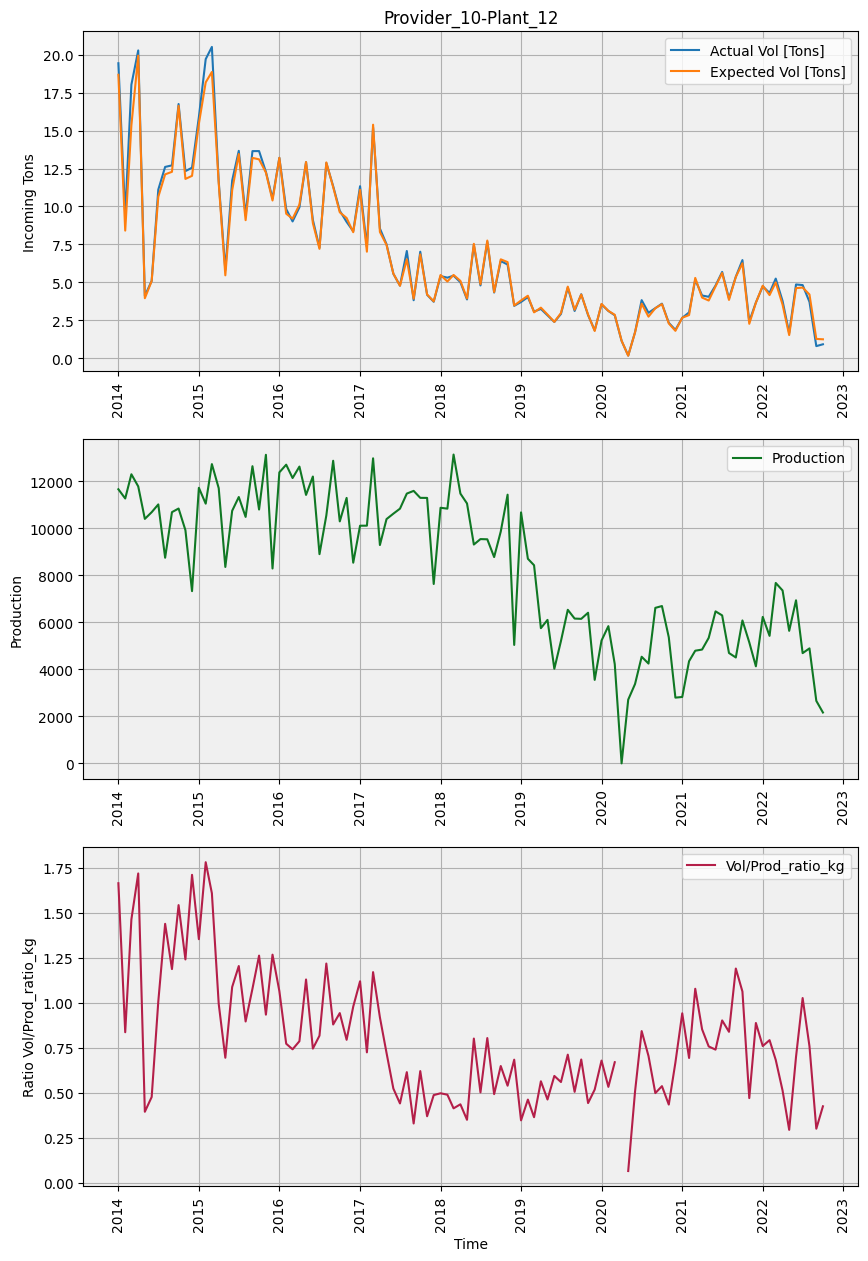

In [43]:
ts_key = "Provider_10-Plant_12"
_df = ts.query(f" ts_key == '{ts_key}'")


x_axis = "Timestamp"
y1_axis = "Actual Vol [Tons]"
y2_axis = "Expected Vol [Tons]"
y3_axis = 'Production' 
y4_axis = "Vol/Prod_ratio_kg"

x = _df[x_axis]
y1 = _df[y1_axis]
y2 = _df[y2_axis]
y3 = _df[y3_axis]
y4 = _df[y4_axis]

#Create a figure of 3 rows X 1 column 
fig, ax = plt.subplots(3,1, figsize=(10,15))

#Subplot [0]
ax[0].plot(x,y1,label=y1_axis,color='#1f76b4')
ax[0].plot(x,y2,label=y2_axis,color='#ff7e0e')
ax[0].set_ylabel("Incoming Tons")
ax[0].set_title(ts_key)

#Subplot [1]
ax[1].plot(x,y3,label=y3_axis,color='#107824')
ax[1].set_ylabel("Production")
ax[1].legend()

#Subplot [2]
ax[2].plot(x,y4,label=y4_axis,color='#b41f49')
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Ratio Vol/Prod_ratio_kg")

#create a function that will modify the generalities of each plot
def set_subplot(axis):
    axis.set_facecolor("#f0f0f0")
    axis.grid(True)
    axis.tick_params(axis="x", rotation=90)
    axis.legend()

[set_subplot(axis) for axis in ax]

plt.show()


### Plot PDF generator (Expected Vs Actual, Production and ratio (Vol/Prod))

In [44]:

'''with PdfPages("Timeseries_Vol_Prod_Ratio_N.pdf") as pdf:
    for ts_key in tqdm(ts["ts_key"].unique()):
        
        _df = ts.query(f" ts_key == '{ts_key}'")

        x_axis = "Timestamp"
        y1_axis = "Actual Vol [Tons]"
        y2_axis = "Expected Vol [Tons]"
        y3_axis = "Production"
        y4_axis = "Vol/Prod_ratio_kg"

        x = _df[x_axis]
        y1 = _df[y1_axis]
        y2 = _df[y2_axis]
        y3 = _df[y3_axis]
        y4 = _df[y4_axis]

        # Turn off interactive mode
        plt.ioff()

        # Activate autolayout so that the whole plot fits into one page
        plt.rcParams["figure.autolayout"] = True

        #Matplotlib uses format Tex to render text, it makes this process slower and here we don't need it so it is better to deactivate it 
        plt.rc("text", usetex=False)

        #Create a figure of 3 rows X 1 column 
        fig, ax = plt.subplots(3,1, figsize=(10,15))

        #Subplot [0]
        ax[0].plot(x,y1,label=y1_axis,color='#1f76b4')
        ax[0].plot(x,y2,label=y2_axis,color='#ff7e0e')
        ax[0].set_ylabel("Incoming Tons")
        ax[0].set_title(ts_key)
        
        #Subplot [1]
        ax[1].plot(x,y3,label=y3_axis,color='#107824')
        ax[1].grid(True)
        ax[1].set_ylabel("Production")
        

        #Subplot [2]
        ax[2].plot(x,y4,label=y4_axis,color='#b41f49')
        ax[2].set_xlabel(x_axis)
        ax[2].set_ylabel("Ratio Vol/Prod_ratio_kg")
        
        #create a function that will modify the generalities of each plot
        def set_subplot(axis):
            axis.set_facecolor("#f0f0f0")
            axis.grid(True)
            axis.tick_params(axis="x", rotation=90)
            axis.legend()
            axis.set_xlim((ts["Timestamp"].min()),(ts["Timestamp"].max()))

        [set_subplot(axis) for axis in ax]


        pdf.savefig(fig)
        plt.close(fig)'''





'with PdfPages("Timeseries_Vol_Prod_Ratio_N.pdf") as pdf:\n    for ts_key in tqdm(ts["ts_key"].unique()):\n        \n        _df = ts.query(f" ts_key == \'{ts_key}\'")\n\n        x_axis = "Timestamp"\n        y1_axis = "Actual Vol [Tons]"\n        y2_axis = "Expected Vol [Tons]"\n        y3_axis = "Production"\n        y4_axis = "Vol/Prod_ratio_kg"\n\n        x = _df[x_axis]\n        y1 = _df[y1_axis]\n        y2 = _df[y2_axis]\n        y3 = _df[y3_axis]\n        y4 = _df[y4_axis]\n\n        # Turn off interactive mode\n        plt.ioff()\n\n        # Activate autolayout so that the whole plot fits into one page\n        plt.rcParams["figure.autolayout"] = True\n\n        #Matplotlib uses format Tex to render text, it makes this process slower and here we don\'t need it so it is better to deactivate it \n        plt.rc("text", usetex=False)\n\n        #Create a figure of 3 rows X 1 column \n        fig, ax = plt.subplots(3,1, figsize=(10,15))\n\n        #Subplot [0]\n        ax[0].plot

### Plot PDF generator (Expected Vs Actual, Production and ratio (Vol/Prod) - Set Y axes)

In [45]:
'''with PdfPages("Timeseries_Vol_Prod_Ratio_SetYaxis.pdf") as pdf:
    for ts_key in tqdm(ts["ts_key"].unique()):
        
        _df = ts.query(f" ts_key == '{ts_key}'")

        x_axis = "Timestamp"
        y1_axis = "Actual Vol [Tons]"
        y2_axis = "Expected Vol [Tons]"
        y3_axis = "Production"
        y4_axis = "Vol/Prod_ratio_kg"

        x = _df[x_axis]
        y1 = _df[y1_axis]
        y2 = _df[y2_axis]
        y3 = _df[y3_axis]
        y4 = _df[y4_axis]

        # Turn off interactive mode
        plt.ioff()

        # Activate autolayout so that the whole plot fits into one page
        plt.rcParams["figure.autolayout"] = True

        #Matplotlib uses format Tex to render text, it makes this process slower and here we don't need it so it is better to deactivate it 
        plt.rc("text", usetex=False)

        #Create a figure of 3 rows X 1 column 
        fig, ax = plt.subplots(3,1, figsize=(10,15))

        #Subplot [0]
        ax[0].plot(x,y1,label=y1_axis,color='#1f76b4')
        ax[0].plot(x,y2,label=y2_axis,color='#ff7e0e')
        ax[0].set_ylabel("Incoming Tons")
        ax[0].set_title(ts_key)
        ax[0].set_ylim((0,1000))
        
        #Subplot [1]
        ax[1].plot(x,y3,label=y3_axis,color='#107824')
        ax[1].grid(True)
        ax[1].set_ylabel("Production")
        
        

        #Subplot [2]
        ax[2].plot(x,y4,label=y4_axis,color='#b41f49')
        ax[2].set_xlabel(x_axis)
        ax[2].set_ylabel("Ratio Vol/Prod_ratio_kg")
        
        #create a function that will modify the generalities of each plot
        def set_subplot(axis):
            axis.set_facecolor("#f0f0f0")
            axis.grid(True)
            axis.tick_params(axis="x", rotation=90)
            axis.legend()
            axis.set_xlim((ts["Timestamp"].min()),(ts["Timestamp"].max()))

        [set_subplot(axis) for axis in ax]


        pdf.savefig(fig)
        plt.close(fig)'''


'with PdfPages("Timeseries_Vol_Prod_Ratio_SetYaxis.pdf") as pdf:\n    for ts_key in tqdm(ts["ts_key"].unique()):\n        \n        _df = ts.query(f" ts_key == \'{ts_key}\'")\n\n        x_axis = "Timestamp"\n        y1_axis = "Actual Vol [Tons]"\n        y2_axis = "Expected Vol [Tons]"\n        y3_axis = "Production"\n        y4_axis = "Vol/Prod_ratio_kg"\n\n        x = _df[x_axis]\n        y1 = _df[y1_axis]\n        y2 = _df[y2_axis]\n        y3 = _df[y3_axis]\n        y4 = _df[y4_axis]\n\n        # Turn off interactive mode\n        plt.ioff()\n\n        # Activate autolayout so that the whole plot fits into one page\n        plt.rcParams["figure.autolayout"] = True\n\n        #Matplotlib uses format Tex to render text, it makes this process slower and here we don\'t need it so it is better to deactivate it \n        plt.rc("text", usetex=False)\n\n        #Create a figure of 3 rows X 1 column \n        fig, ax = plt.subplots(3,1, figsize=(10,15))\n\n        #Subplot [0]\n        ax[

In [46]:
ts['Production'].replace(0, np.NaN, inplace=True)
ts.info()   

<class 'pandas.core.frame.DataFrame'>
Index: 25761 entries, 20004 to 23624
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            25761 non-null  datetime64[ns]
 1   ts_key               25761 non-null  object        
 2   Actual Vol [Tons]    25761 non-null  float32       
 3   Expected Vol [Tons]  25761 non-null  float32       
 4   Plant                25761 non-null  object        
 5   Production           25509 non-null  float64       
 6   Actual Vol [Kg]      25761 non-null  float32       
 7   Expected Vol [Kg]    25761 non-null  float32       
 8   Vol/Prod_ratio_ton   25509 non-null  float64       
 9   Vol/Prod_ratio_kg    25509 non-null  float64       
 10  ts_len               25761 non-null  int64         
dtypes: datetime64[ns](1), float32(4), float64(3), int64(1), object(2)
memory usage: 2.0+ MB


In [47]:
ts.reset_index(drop= True)
ts['Vol/Prod_ratio_kg'] = ts['Vol/Prod_ratio_kg'].interpolate()

In [48]:
ts.head()

,Timestamp,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant,Production,Actual Vol [Kg],Expected Vol [Kg],Vol/Prod_ratio_ton,Vol/Prod_ratio_kg,ts_len
20004,2015-01-01,Provider_10-Plant_1,2.344,3.109,Plant_1,48144.0,2344.0,3109.0,0.00005,0.04869,94
20005,2015-02-01,Provider_10-Plant_1,0.000,0.000,Plant_1,57400.0,0.0,0.0,0.00000,0.00000,94
20006,2015-03-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51290.0,0.0,0.0,0.00000,0.00000,94
20007,2015-04-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51489.0,0.0,0.0,0.00000,0.00000,94
20008,2015-05-01,Provider_10-Plant_1,0.000,0.000,Plant_1,60348.0,0.0,0.0,0.00000,0.00000,94


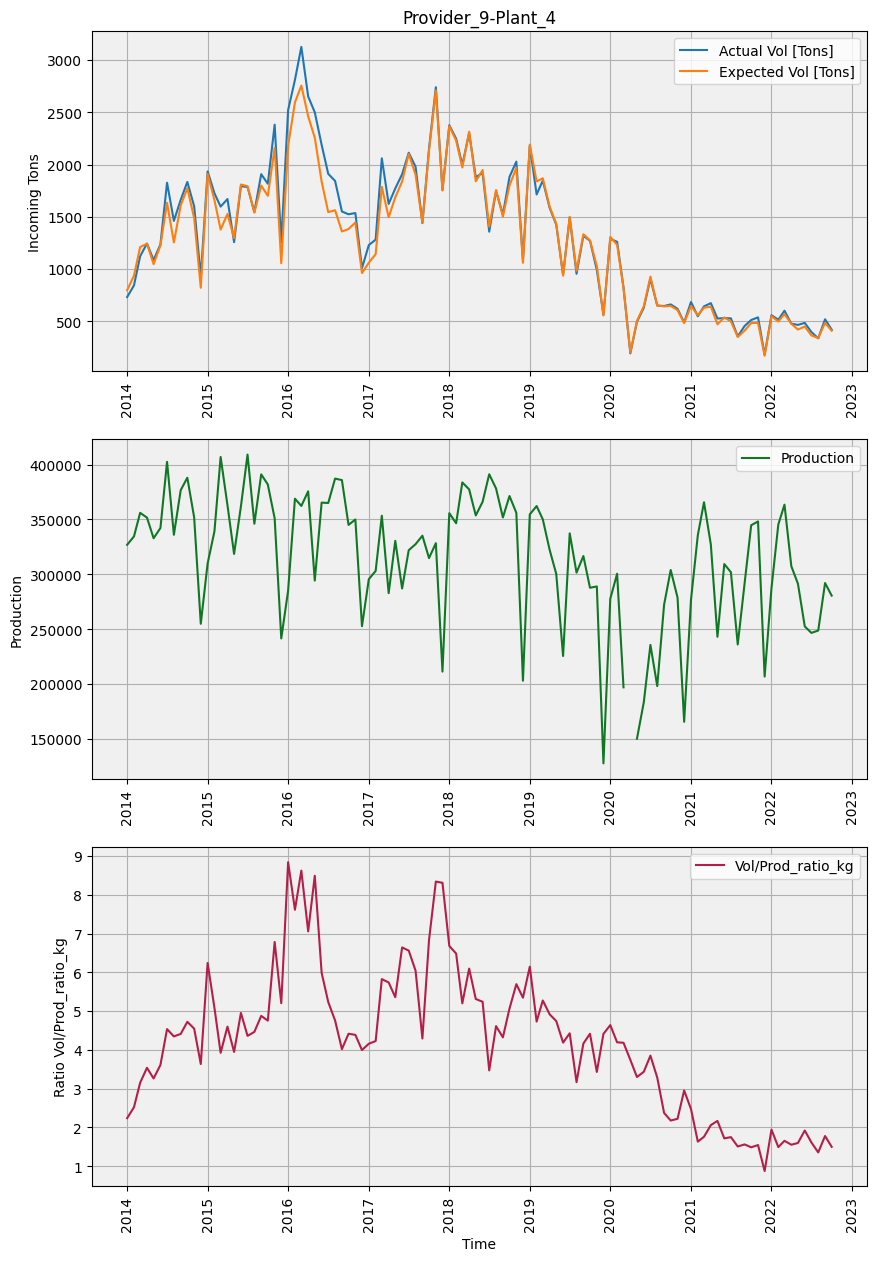

In [49]:
ts_key = "Provider_9-Plant_4"
_df = ts.query(f" ts_key == '{ts_key}'")


x_axis = "Timestamp"
y1_axis = "Actual Vol [Tons]"
y2_axis = "Expected Vol [Tons]"
y3_axis = 'Production' 
y4_axis = "Vol/Prod_ratio_kg"

x = _df[x_axis]
y1 = _df[y1_axis]
y2 = _df[y2_axis]
y3 = _df[y3_axis]
y4 = _df[y4_axis]

#Create a figure of 3 rows X 1 column 
fig, ax = plt.subplots(3,1, figsize=(10,15))

#Subplot [0]
ax[0].plot(x,y1,label=y1_axis,color='#1f76b4')
ax[0].plot(x,y2,label=y2_axis,color='#ff7e0e')
ax[0].set_ylabel("Incoming Tons")
ax[0].set_title(ts_key)

#Subplot [1]
ax[1].plot(x,y3,label=y3_axis,color='#107824')
ax[1].set_ylabel("Production")
ax[1].legend()

#Subplot [2]
ax[2].plot(x,y4,label=y4_axis,color='#b41f49')
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Ratio Vol/Prod_ratio_kg")

#create a function that will modify the generalities of each plot
def set_subplot(axis):
    axis.set_facecolor("#f0f0f0")
    axis.grid(True)
    axis.tick_params(axis="x", rotation=90)
    axis.legend()

[set_subplot(axis) for axis in ax]

plt.show()

# Seasonal Patterns

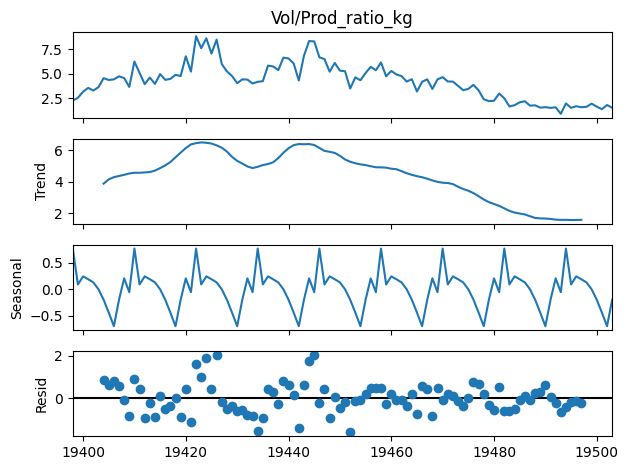

In [50]:
ts_key = "Provider_9-Plant_4"
decomposition = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"],period =12, model='additive') 
figure = decomposition.plot()
plt.show()

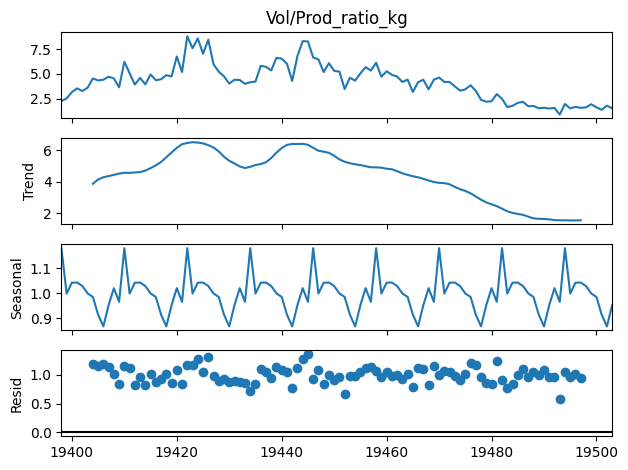

In [51]:
ts_key = "Provider_9-Plant_4"
decomposition = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"],period =12, model='multiplicative') 
figure = decomposition.plot()
plt.show()

# Dependence

## ACF

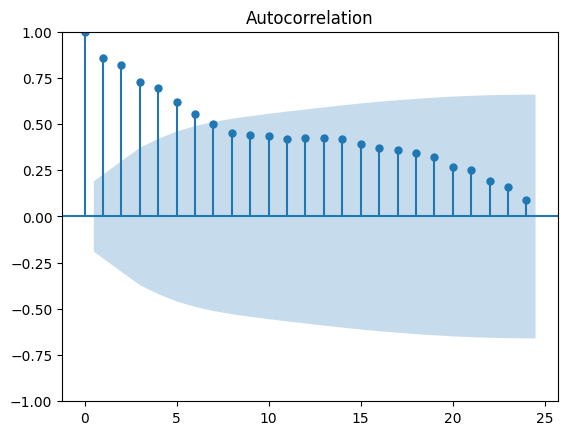

In [52]:
ts_key = "Provider_9-Plant_4"
acf_plot = plot_acf(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], lags=24)

## PACF

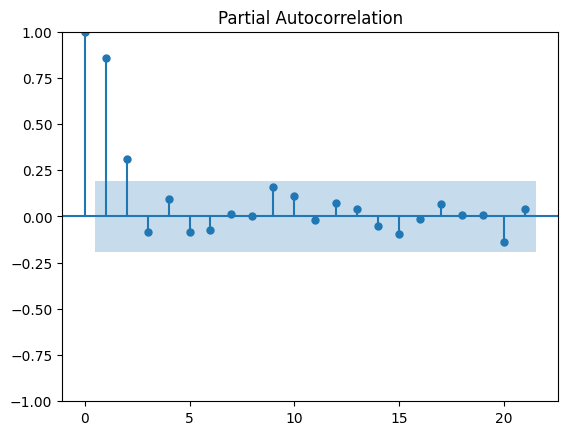

In [53]:
ts_key = "Provider_9-Plant_4"
pacf_plot = plot_pacf(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"])

# Stationarity

The stationarity of a series can be checked by examining the distribution of the series: we split the series into 2 contiguous parts and compute the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

In [54]:
ts_key = "Provider_9-Plant_4"
X = ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"].values
split =  int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean:')
print('chunk1: %.2f vs chunk2: %.2f' % (mean1, mean2))
print('variance:')
print('chunk1: %.2f vs chunk2: %.2f' % (var1, var2))

mean:
chunk1: 5.27 vs chunk2: 3.12
variance:
chunk1: 2.41 vs chunk2: 2.06


## Test for Satationarity (Augmented Dickey-Fuller (ADF))

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root. b

In [55]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.620222
p-value: 0.472613
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


So, for this case as the ADF statistics= -1.6 is > - 2.9 so this time series is non stationary 

/tmp/ipykernel_10310/1008623461.py:83: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/root/anaconda3/envs/env_python38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


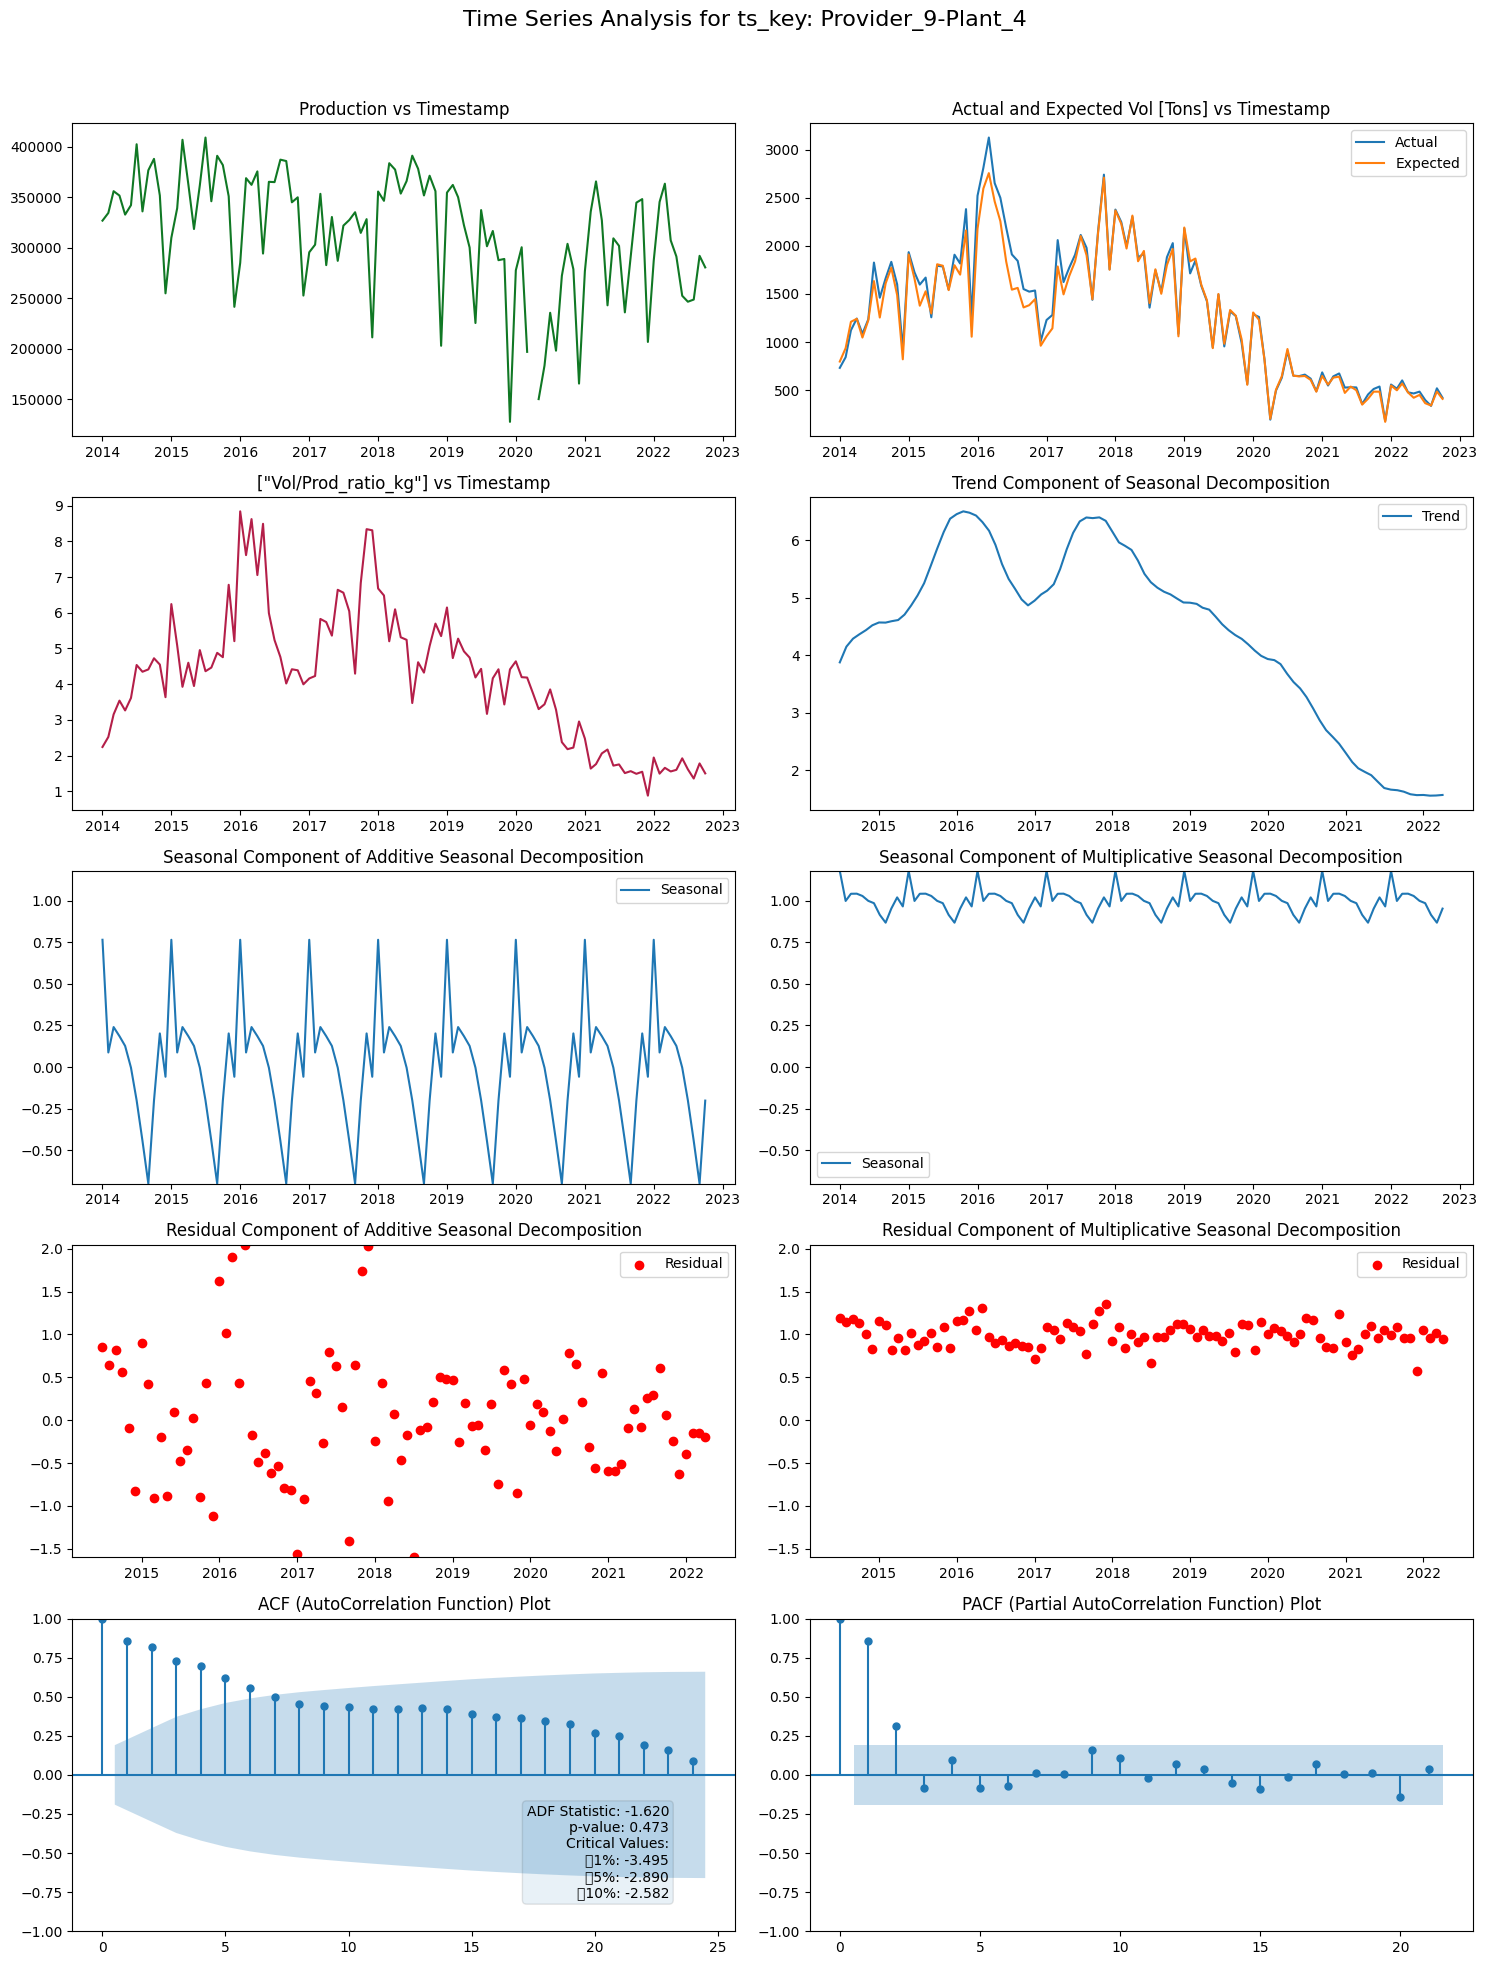

In [56]:
# Set the ts_key
ts_key = "Provider_9-Plant_4"

# Create a figure with 5 rows and 2 columns
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

# Add figure title
fig.suptitle('Time Series Analysis for ts_key: {}'.format(ts_key), fontsize=16)


# Plot 1: Production vs Timestamp
axes[0, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Production"], color='#107824')
axes[0, 0].set_title('Production vs Timestamp')

# Plot 2: Actual Vol [Kg] and Expected Vol [Kg] vs Timestamp
axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Actual Vol [Tons]"], label='Actual')
axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Expected Vol [Tons]"], label='Expected')
axes[0, 1].legend()
axes[0, 1].set_title('Actual and Expected Vol [Tons] vs Timestamp')

# Plot 3: ["Vol/Prod_ratio_kg"] vs Timestamp
axes[1, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"],color='#b41f49')
axes[1, 0].set_title('["Vol/Prod_ratio_kg"] vs Timestamp')

# Plot 4: Trend Component of Seasonal Decomposition
decomposition_additive = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], period=12, model='additive') 
axes[1, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_additive.trend, label='Trend')
axes[1, 1].legend()
axes[1, 1].set_title('Trend Component of Seasonal Decomposition')

# Plot 5: Seasonal Component and Residual of Additive Seasonal Decomposition
axes[2, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_additive.seasonal, label='Seasonal')
axes[3, 0].scatter(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_additive.resid, label='Residual', color='red')
axes[2, 0].legend()
axes[3, 0].legend()
axes[2, 0].set_title('Seasonal Component of Additive Seasonal Decomposition')
axes[3, 0].set_title('Residual Component of Additive Seasonal Decomposition')

# Plot 6: Seasonal Component and Residual of Multiplicative Seasonal Decomposition
decomposition_multiplicative = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], period=12, model='multiplicative') 
axes[2, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_multiplicative.seasonal, label='Seasonal')
axes[3, 1].scatter(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_multiplicative.resid, label='Residual', color='red')
axes[2, 1].legend()
axes[3, 1].legend()
axes[2, 1].set_title('Seasonal Component of Multiplicative Seasonal Decomposition')
axes[3, 1].set_title('Residual Component of Multiplicative Seasonal Decomposition')

# Set y-axis limits for Residual Component plots
min_resid = min(decomposition_additive.resid.min(), decomposition_multiplicative.resid.min())
max_resid = max(decomposition_additive.resid.max(), decomposition_multiplicative.resid.max())
axes[3, 0].set_ylim(min_resid, max_resid)
axes[3, 1].set_ylim(min_resid, max_resid)

# Set y-axis limits for Seasonal Component plots
min_seasonal = min(decomposition_additive.seasonal.min(), decomposition_multiplicative.seasonal.min())
max_seasonal = max(decomposition_additive.seasonal.max(), decomposition_multiplicative.seasonal.max())
axes[2, 0].set_ylim(min_seasonal, max_seasonal)
axes[2, 1].set_ylim(min_seasonal, max_seasonal)

# Annotate with ADF statistic, p-value, and critical values
X = ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"].values
result = adfuller(X)
adf_statistic, p_value, critical_values = result[0], result[1], result[4]

axes[4, 0].annotate(f'ADF Statistic: {adf_statistic:.3f}\n'
                    f'p-value: {p_value:.3f}\n'
                    f'Critical Values:\n'
                    f'\t1%: {critical_values["1%"]:.3f}\n'
                    f'\t5%: {critical_values["5%"]:.3f}\n'
                    f'\t10%: {critical_values["10%"]:.3f}',
                    xy=(0.9, 0.1), xycoords='axes fraction',
                    ha='right', va='bottom', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# Plot 7: ACF (AutoCorrelation Function) Plot
acf_plot = plot_acf(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], lags=24, ax=axes[4, 0])
axes[4, 0].set_title('ACF (AutoCorrelation Function) Plot')

# Plot 8: PACF (Partial AutoCorrelation Function) Plot
pacf_plot = plot_pacf(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], ax=axes[4, 1])
axes[4, 1].set_title('PACF (Partial AutoCorrelation Function) Plot')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




In [59]:
'''pdf_filename = "Time_Series_Analysis.pdf"

with PdfPages(pdf_filename) as pdf:
    for ts_key in tqdm(ts["ts_key"].unique()):
        # Create a figure with 5 rows and 2 columns
        fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

        # Add figure title
        fig.suptitle('Time Series Analysis for ts_key: {}'.format(ts_key), fontsize=16)


        # Plot 1: Production vs Timestamp
        axes[0, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Production"], color='#107824')
        axes[0, 0].set_title('Production vs Timestamp')

        # Plot 2: Actual Vol [Kg] and Expected Vol [Kg] vs Timestamp
        axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Actual Vol [Tons]"], label='Actual')
        axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Expected Vol [Tons]"], label='Expected')
        axes[0, 1].legend()
        axes[0, 1].set_title('Actual and Expected Vol [Tons] vs Timestamp')

        # Plot 3: ["Vol/Prod_ratio_kg"] vs Timestamp
        axes[1, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"],color='#b41f49')
        axes[1, 0].set_title('["Vol/Prod_ratio_kg"] vs Timestamp')

        # Plot 4: Trend Component of Seasonal Decomposition
        decomposition_additive = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], period = 12,model='additive') 
        axes[1, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_additive.trend, label='Trend')
        axes[1, 1].legend()
        axes[1, 1].set_title('Trend Component of Seasonal Decomposition')

        
        # Plot 5: Seasonal Component and Residual of Additive Seasonal Decomposition
        axes[2, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_additive.seasonal, label='Seasonal')
        axes[3, 0].scatter(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_additive.resid, label='Residual', color='red')
        axes[2, 0].legend()
        axes[3, 0].legend()
        axes[2, 0].set_title('Seasonal Component of Additive Seasonal Decomposition')
        axes[3, 0].set_title('Residual Component of Additive Seasonal Decomposition')

            # Plot 6: Seasonal Component and Residual of Multiplicative Seasonal Decomposition

        if (ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"] > 0).all():
            decomposition_multiplicative = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"],period = 12, model='multiplicative') 
            axes[2, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_multiplicative.seasonal, label='Seasonal')
            axes[3, 1].scatter(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_multiplicative.resid, label='Residual', color='red')
            axes[2, 1].legend()
            axes[3, 1].legend()
            axes[2, 1].set_title('Seasonal Component of Multiplicative Seasonal Decomposition')
            axes[3, 1].set_title('Residual Component of Multiplicative Seasonal Decomposition')
            # Set y-axis limits for Residual Component plots
            min_resid = min(decomposition_additive.resid.min(), decomposition_multiplicative.resid.min())
            max_resid = max(decomposition_additive.resid.max(), decomposition_multiplicative.resid.max())
            axes[3, 0].set_ylim(min_resid, max_resid)
            axes[3, 1].set_ylim(min_resid, max_resid)
            # Set y-axis limits for Seasonal Component plots
            min_seasonal = min(decomposition_additive.seasonal.min(), decomposition_multiplicative.seasonal.min())
            max_seasonal = max(decomposition_additive.seasonal.max(), decomposition_multiplicative.seasonal.max())
            axes[2, 0].set_ylim(min_seasonal, max_seasonal)
            axes[2, 1].set_ylim(min_seasonal, max_seasonal)
      

        # Annotate with ADF statistic, p-value, and critical values
        X = ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"].values
        result = adfuller(X)
        adf_statistic, p_value, critical_values = result[0], result[1], result[4]

        axes[4, 0].annotate(f'ADF Statistic: {adf_statistic:.3f}\n'
                            f'p-value: {p_value:.3f}\n'
                            f'Critical Values:\n'
                            f'\t1%: {critical_values["1%"]:.3f}\n'
                            f'\t5%: {critical_values["5%"]:.3f}\n'
                            f'\t10%: {critical_values["10%"]:.3f}',
                            xy=(0.9, 0.1), xycoords='axes fraction',
                            ha='right', va='bottom', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

        # Plot 7: ACF (AutoCorrelation Function) Plot
        acf_plot = plot_acf(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], ax=axes[4, 0])
        axes[4, 0].set_title('ACF (AutoCorrelation Function) Plot')

        # Plot 8: PACF (Partial AutoCorrelation Function) Plot
        pacf_plot = plot_pacf(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], ax=axes[4, 1])
        axes[4, 1].set_title('PACF (Partial AutoCorrelation Function) Plot')

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Save figure to PDF
        pdf.savefig(fig)
        plt.close(fig)'''
       

'pdf_filename = "Time_Series_Analysis.pdf"\n\nwith PdfPages(pdf_filename) as pdf:\n    for ts_key in tqdm(ts["ts_key"].unique()):\n        # Create a figure with 5 rows and 2 columns\n        fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))\n\n        # Add figure title\n        fig.suptitle(\'Time Series Analysis for ts_key: {}\'.format(ts_key), fontsize=16)\n\n\n        # Plot 1: Production vs Timestamp\n        axes[0, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Production"], color=\'#107824\')\n        axes[0, 0].set_title(\'Production vs Timestamp\')\n\n        # Plot 2: Actual Vol [Kg] and Expected Vol [Kg] vs Timestamp\n        axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Actual Vol [Tons]"], label=\'Actual\')\n        axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Expected Vol [Tons]"], label=\'Expected\')\n        axes[0, 1].legend()\n        axes[0, 1].se

In [58]:
'''pdf_filename = "Time_Series_Analysis.pdf"

with PdfPages(pdf_filename) as pdf:
    for ts_key in tqdm(ts["ts_key"].unique()):
        # Create a figure with 5 rows and 2 columns
        fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

        # Add figure title
        fig.suptitle('Time Series Analysis for ts_key: {}'.format(ts_key), fontsize=16)

        # Plot 1: Production vs Timestamp
        axes[0, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Production"], color='#107824')
        axes[0, 0].set_title('Production vs Timestamp')

        # Plot 2: Actual Vol [Kg] and Expected Vol [Kg] vs Timestamp
        axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Actual Vol [Tons]"], label='Actual')
        axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Expected Vol [Tons]"], label='Expected')
        axes[0, 1].legend()
        axes[0, 1].set_title('Actual and Expected Vol [Tons] vs Timestamp')

        # Plot 3: ["Vol/Prod_ratio_kg"] vs Timestamp
        axes[1, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], color='#b41f49')
        axes[1, 0].set_title('["Vol/Prod_ratio_kg"] vs Timestamp')

        # Plot 4: Trend Component of Seasonal Decomposition
        decomposition_additive = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], period=12, model='additive') 
        axes[1, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_additive.trend, label='Trend')
        axes[1, 1].legend()
        axes[1, 1].set_title('Trend Component of Seasonal Decomposition')

        # Plot 5: Seasonal Component and Residual of Additive Seasonal Decomposition
        axes[2, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_additive.seasonal, label='Seasonal')
        axes[3, 0].scatter(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_additive.resid, label='Residual', color='red')
        axes[2, 0].legend()
        axes[3, 0].legend()
        axes[2, 0].set_title('Seasonal Component of Additive Seasonal Decomposition')
        axes[3, 0].set_title('Residual Component of Additive Seasonal Decomposition')

        # Check if there are zero or negative values in the column
        if (ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"] <= 0).any():
            axes[2, 1].set_title('Multiplicative Seasonal Decomposition Skipped (Zero or Negative Values)')
            axes[3, 1].set_title('')
        else:
            # Plot 6: Seasonal Component and Residual of Multiplicative Seasonal Decomposition
            decomposition_multiplicative = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"],period = 12, model='multiplicative') 
            axes[2, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_multiplicative.seasonal, label='Seasonal')
            axes[3, 1].scatter(ts[ts["ts_key"] == ts_key]["Timestamp"], decomposition_multiplicative.resid, label='Residual', color='red')
            axes[2, 1].legend()
            axes[3, 1].legend()
            axes[2, 1].set_title('Seasonal Component of Multiplicative Seasonal Decomposition')
            axes[3, 1].set_title('Residual Component of Multiplicative Seasonal Decomposition')
            # Set y-axis limits for Residual Component plots
            min_resid = min(decomposition_additive.resid.min(), decomposition_multiplicative.resid.min())
            max_resid = max(decomposition_additive.resid.max(), decomposition_multiplicative.resid.max())
            axes[3, 0].set_ylim(min_resid, max_resid)
            axes[3, 1].set_ylim(min_resid, max_resid)
            # Set y-axis limits for Seasonal Component plots
            min_seasonal = min(decomposition_additive.seasonal.min(), decomposition_multiplicative.seasonal.min())
            max_seasonal = max(decomposition_additive.seasonal.max(), decomposition_multiplicative.seasonal.max())
            axes[2, 0].set_ylim(min_seasonal, max_seasonal)
            axes[2, 1].set_ylim(min_seasonal, max_seasonal)

        
        # Annotate with ADF statistic, p-value, and critical values
        X = ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"].values
        result = adfuller(X)
        adf_statistic, p_value, critical_values = result[0], result[1], result[4]

        axes[4, 0].annotate(f'ADF Statistic: {adf_statistic:.3f}\n'
                            f'p-value: {p_value:.3f}\n'
                            f'Critical Values:\n'
                            f'\t1%: {critical_values["1%"]:.3f}\n'
                            f'\t5%: {critical_values["5%"]:.3f}\n'
                            f'\t10%: {critical_values["10%"]:.3f}',
                            xy=(0.9, 0.1), xycoords='axes fraction',
                            ha='right', va='bottom', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

        # Plot 7: ACF (AutoCorrelation Function) Plot
        acf_plot = plot_acf(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], ax=axes[4, 0])
        axes[4, 0].set_title('ACF (AutoCorrelation Function) Plot')

        # Plot 8: PACF (Partial AutoCorrelation Function) Plot
        pacf_plot = plot_pacf(ts[ts["ts_key"] == ts_key]["Vol/Prod_ratio_kg"], ax=axes[4, 1])
        axes[4, 1].set_title('PACF (Partial AutoCorrelation Function) Plot')

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Save figure to PDF
        pdf.savefig(fig)
        plt.close(fig)
       '''


'pdf_filename = "Time_Series_Analysis.pdf"\n\nwith PdfPages(pdf_filename) as pdf:\n    for ts_key in tqdm(ts["ts_key"].unique()):\n        # Create a figure with 5 rows and 2 columns\n        fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))\n\n        # Add figure title\n        fig.suptitle(\'Time Series Analysis for ts_key: {}\'.format(ts_key), fontsize=16)\n\n        # Plot 1: Production vs Timestamp\n        axes[0, 0].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Production"], color=\'#107824\')\n        axes[0, 0].set_title(\'Production vs Timestamp\')\n\n        # Plot 2: Actual Vol [Kg] and Expected Vol [Kg] vs Timestamp\n        axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Actual Vol [Tons]"], label=\'Actual\')\n        axes[0, 1].plot(ts[ts["ts_key"] == ts_key]["Timestamp"], ts[ts["ts_key"] == ts_key]["Expected Vol [Tons]"], label=\'Expected\')\n        axes[0, 1].legend()\n        axes[0, 1].set_

# Feature Selection

In [64]:
def create_features(ts):
    ts= ts.copy()
    ts['Month']=ts['Timestamp'].dt.month
    return ts

ts=create_features(ts)

In [65]:
ts.head()

,Timestamp,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant,Production,Actual Vol [Kg],Expected Vol [Kg],Vol/Prod_ratio_ton,Vol/Prod_ratio_kg,ts_len,Month
20004,2015-01-01,Provider_10-Plant_1,2.344,3.109,Plant_1,48144.0,2344.0,3109.0,0.00005,0.04869,94,1
20005,2015-02-01,Provider_10-Plant_1,0.000,0.000,Plant_1,57400.0,0.0,0.0,0.00000,0.00000,94,2
20006,2015-03-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51290.0,0.0,0.0,0.00000,0.00000,94,3
20007,2015-04-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51489.0,0.0,0.0,0.00000,0.00000,94,4
20008,2015-05-01,Provider_10-Plant_1,0.000,0.000,Plant_1,60348.0,0.0,0.0,0.00000,0.00000,94,5
